In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random
from scipy.stats import gaussian_kde
import numpy as np
# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from scipy.integrate import cumtrapz
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pickle
from sklearn.metrics import f1_score,roc_auc_score


import timm
from timm.models.efficientnet import *

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict


import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage

import glob

/home/joe1007/miniconda3/envs/e2d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_area_df=pd.read_csv("/ssd7/ICCV2025_COVID19/processing_by_hospital_0/train_area_df1_challenge.csv")
valid_area_df=pd.read_csv("/ssd7/ICCV2025_COVID19/processing_by_hospital_0/valid_area_df1_challenge.csv")

In [3]:
train_area_df["ct_path"]=train_area_df["path"].apply(lambda x: "/".join(x.split("/")[:-1]))
valid_area_df["ct_path"]=valid_area_df["path"].apply(lambda x: "/".join(x.split("/")[:-1]))

train_area_df["ct_slice"]=train_area_df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
valid_area_df["ct_slice"]=valid_area_df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))

train_area_df.sort_values(by=['ct_path', 'ct_slice'], inplace=True)
valid_area_df.sort_values(by=['ct_path', 'ct_slice'], inplace=True)

In [4]:
def sum_max_with_adjustment(a, w=0.4):
    # Adjust the array based on its length
    if len(a) < 60:
        # Remove the first 20 and the last 20 elements
        adjusted_a = a[20:-20]
    else:
        # Remove the last 40 and the first 20 elements
        adjusted_a = a[20:-45]
    
    l = len(adjusted_a)
    k = int(np.ceil(l * w))
    d = 0
    tmp_max = 0
    
    for i in range(l - k + 1):
        current_sum = np.sum(adjusted_a[i:i+k])
        if current_sum > tmp_max:
            tmp_max = current_sum
            d = i
    
    # Adjust d and d+k back to the original array's index space
    if len(a) < 60:
        d += 20  # Adjust index if the array was shorter than 60
    else:
        d += 20  # Always adjust by 20 because we always remove the first 20 elements
    
    return d, d + k    

In [5]:
from scipy.integrate import cumtrapz
def kd_sampling(area_list,start_index,k,sample):
# 提供的数据
    data = area_list
    data_np = np.array(data)
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 计算KDE曲线下的面积，以此近似CDF
    cdf = cumtrapz(kde_values, x_grid, initial=0)
    cdf /= cdf[-1]  # 归一化，使得CDF的最大值为1
    # 找出等分的百分位数对应的值作为区间边界
    percentiles = np.linspace(0, 1, k+1)
    bins_percentiles = np.interp(percentiles, cdf, x_grid)

    # 根据新的区间边界进行抽样和绘图过程的剩余部分
    bin_counts_percentiles = [sum((data >= bins_percentiles[i]) & (data < bins_percentiles[i+1])) for i in range(len(bins_percentiles)-1)]
    samples_per_bin_percentiles = np.ones(k, dtype=int)
    remaining_samples_percentiles = sample - k

    proportions_percentiles = np.array(bin_counts_percentiles) / sum(bin_counts_percentiles)
    additional_samples_percentiles = np.floor(proportions_percentiles * remaining_samples_percentiles).astype(int)
    samples_per_bin_percentiles += additional_samples_percentiles

    remaining_samples_percentiles -= additional_samples_percentiles.sum()
    while remaining_samples_percentiles > 0:
        indices_percentiles = np.argsort(proportions_percentiles)[::-1][:remaining_samples_percentiles]
        for i in indices_percentiles:
            samples_per_bin_percentiles[i] += 1
            remaining_samples_percentiles -= 1

    sampled_values_corrected_percentiles = []
    for i in range(len(bins_percentiles) - 1):
        bin_data = data_np[(data_np >= bins_percentiles[i]) & (data_np < bins_percentiles[i+1])]
        samples_count = samples_per_bin_percentiles[i]
        if len(bin_data) <= samples_count:
            sampled_values_corrected_percentiles.extend(bin_data.tolist())
        else:
            sampled_values_corrected_percentiles.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected_percentiles = np.sort(sampled_values_corrected_percentiles)
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected_percentiles]
    sampled_indices = [x+start_index for x in sampled_indices]
    #print(sampled_indices)
    return sampled_indices

In [6]:
ct_path_list=train_area_df["ct_path"].unique()
train_dic={}
for i in tqdm(range(len(ct_path_list))):
    tmp_df=train_area_df[train_area_df["ct_path"]==ct_path_list[i]].reset_index(drop=True)
    tmp_df=train_area_df[train_area_df["ct_path"]==ct_path_list[i]].reset_index(drop=True)
    #train_dic[ct_path_list[i]]=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    #train_dic[ct_path_list[i]]=[list(sum_max_with_adjustment(tmp_df["area"].values,0.5)),len(tmp_df)]
    d1,d2=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    train_dic[ct_path_list[i]]=[d1,d2]
    k=[]
    for j in range(len(tmp_df['area'][d1:d2])):
        k.append(tmp_df['area'][j+d1])
    train_dic[ct_path_list[i]].append(k)
    #print(train_dic[ct_path_list[i]][2],d1,d2)
    if d2-d1>=8:
        train_dic[ct_path_list[i]].append(sorted(kd_sampling(train_dic[ct_path_list[i]][2],d1,4,8)))
    elif (d2-d1)>=2 and (d2-d1)<8:
        train_dic[ct_path_list[i]].append(sorted([random.randint(d1, d2-1) for _ in range(8)]))
    else:
        train_dic[ct_path_list[i]].append([d1 for _ in range(8)])

  0%|          | 0/338 [00:00<?, ?it/s]

100%|██████████| 338/338 [00:08<00:00, 40.12it/s]


In [7]:
for i in range(len(train_dic)):
    print(train_dic[ct_path_list[i]][3],train_dic[ct_path_list[i]][0],train_dic[ct_path_list[i]][1])

[151, 165, 178, 183, 202, 207, 218, 266] 145 270
[58, 60, 63, 78, 114, 118, 135, 157] 54 161
[109, 138, 170, 185, 187, 196, 205, 214] 105 261
[20, 20, 20, 20, 20, 20, 20, 20] 20 20
[95, 127, 132, 148, 169, 172, 176, 193] 80 199
[91, 112, 121, 137, 161, 162, 204, 211] 86 238
[29, 33, 36, 38, 43, 52, 56, 57] 23 59
[127, 184, 218, 236, 239, 250, 286, 296] 125 306
[107, 110, 123, 133, 140, 164, 166, 189] 100 200
[20, 23, 36, 38, 42, 48, 50, 52] 20 59
[85, 110, 114, 130, 147, 162, 172, 184] 83 187
[86, 90, 92, 107, 110, 120, 126, 130] 80 141
[97, 133, 144, 145, 181, 184, 202, 211] 95 221
[167, 189, 200, 202, 211, 229, 243, 285] 147 332
[100, 114, 148, 173, 188, 195, 230, 240] 96 246
[24, 25, 27, 28, 29, 29, 29, 30] 24 31
[76, 80, 101, 141, 159, 165, 187, 195] 71 223
[81, 88, 89, 116, 123, 125, 149, 173] 79 182
[84, 102, 112, 152, 178, 194, 211, 219] 81 223
[87, 108, 130, 135, 147, 172, 179, 203] 86 208
[121, 130, 133, 173, 182, 192, 215, 230] 121 261
[20, 20, 20, 20, 20, 20, 20, 20] 20 20
[

In [8]:
ct_path_list=valid_area_df["ct_path"].unique()
valid_dic={}
for i in tqdm(range(len(ct_path_list))):
    tmp_df=valid_area_df[valid_area_df["ct_path"]==ct_path_list[i]].reset_index(drop=True)
    #valid_dic[ct_path_list[i]]=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    #valid_dic[ct_path_list[i]]=[list(sum_max_with_adjustment(tmp_df["area"].values,0.5)),len(tmp_df)]
    d1,d2=list(sum_max_with_adjustment(tmp_df["area"].values,0.5))
    valid_dic[ct_path_list[i]]=[d1,d2]
    k=[]
    for j in range(len(tmp_df['area'][d1:d2])):
        k.append(tmp_df['area'][j+d1])
    valid_dic[ct_path_list[i]].append(k)
    #print(valid_dic[ct_path_list[i]][2],d1,d2)
    if d2-d1>=8:
        valid_dic[ct_path_list[i]].append(sorted(kd_sampling(valid_dic[ct_path_list[i]][2],d1,4,8)))
    elif (d2-d1)>=2 and (d2-d1)<8:
        valid_dic[ct_path_list[i]].append(sorted([random.randint(d1, d2-1) for _ in range(8)]))
    else:
        valid_dic[ct_path_list[i]].append([d1 for _ in range(8)])

    

100%|██████████| 88/88 [00:00<00:00, 161.41it/s]


In [9]:
for i in range(len(valid_dic)):
    print(valid_dic[ct_path_list[i]][3],valid_dic[ct_path_list[i]][0],valid_dic[ct_path_list[i]][1])

[23, 23, 24, 24, 25, 26, 27, 27] 23 28
[95, 111, 126, 147, 149, 182, 185, 213] 91 217
[103, 133, 144, 154, 155, 208, 212, 224] 102 238
[85, 117, 144, 169, 179, 184, 187, 194] 75 210
[182, 213, 240, 278, 281, 310, 316, 322] 168 327
[74, 81, 86, 103, 106, 115, 120, 127] 73 133
[27, 28, 29, 30, 31, 32, 33] 27 35
[131, 132, 141, 150, 175, 183, 193, 224] 103 225
[105, 122, 145, 153, 186, 197, 241, 242] 102 284
[104, 111, 134, 137, 142, 169, 223, 234] 100 252
[89, 115, 119, 126, 155, 171, 207, 214] 88 227
[145, 150, 180, 186, 205, 210, 235, 261] 129 292
[58, 63, 85, 90, 102, 113, 141, 167] 54 168
[133, 134, 142, 168, 199, 205, 210, 216] 91 231
[102, 147, 169, 191, 195, 197, 221, 222] 99 236
[143, 152, 159, 161, 162, 183, 211, 216] 99 258
[162, 163, 190, 208, 209, 221, 244, 267] 141 298
[20, 20, 20, 20, 20, 20, 20, 20] 20 20
[20, 20, 20, 20, 20, 20, 20, 20] 20 20
[23, 23, 24, 26, 27, 27, 27, 27] 23 29
[96, 112, 134, 158, 162, 166, 207, 219] 87 224
[89, 120, 129, 156, 197, 209, 214, 222] 82 23

In [10]:
with open('/ssd7/ICCV2025_COVID19/processing_by_hospital_0/kde_train_dic_challenge.pickle', 'wb') as handle:
    pickle.dump(train_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('/ssd7/ICCV2025_COVID19/processing_by_hospital_0/kde_valid_dic_challenge.pickle', 'wb') as handle:
    pickle.dump(valid_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
from scipy.stats import gaussian_kde
import numpy as np

# 提供的数据
data = valid_dic['/ssd7/ICCV2025_COVID19/track1_by_hospital/hospital_0/valid_pure_crop_challenge/covid/ct_scan_0'][2:][0]
# 使用gaussian_kde计算Kernel Density Estimate
kde = gaussian_kde(data)

# 为了绘制KDE, 我们需要一个范围和密度值
x_grid = np.linspace(min(data), max(data), 100)
kde_values = kde.evaluate(x_grid)
print(data)

[59702.0, 61236.0, 62101.0, 61553.0, 60120.0]


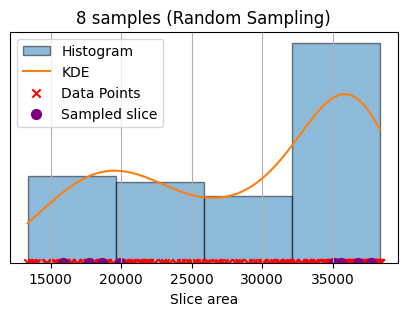

In [24]:
# 提供的数据
data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_1'][2:][0]
# 使用gaussian_kde计算Kernel Density Estimate
kde = gaussian_kde(data)

# 为了绘制KDE, 我们需要一个范围和密度值
x_grid = np.linspace(min(data), max(data), 100)
kde_values = kde.evaluate(x_grid)


data_np = np.array(data)
# 调整抽样策略，使得在数据更密集的区间抽取更多样本，而在稀疏的区间可能不抽取样本
samples_per_bin_adjusted = []
samples_count_per_bin = []

# 指定区间数
k = 4

# 创建k个区间
bins = np.linspace(min(data), max(data), k+1)

# 从data中简单随机抽取16个样本
random_sampled_values = np.random.choice(data_np, 8, replace=False)
random_sampled_values = np.sort(random_sampled_values)  # 排序，以便观察

# 绘制直方图、KDE和简单随机抽样结果
plt.figure(figsize=(5, 3))
plt.hist(data_np, bins=bins, density=True, alpha=0.5, edgecolor='black', label='Histogram')
plt.plot(x_grid, kde_values, label='KDE')
plt.scatter(data_np, np.zeros_like(data_np), color='red', marker='x', label='Data Points')

# 标记简单随机抽样得到的样本点
plt.scatter(random_sampled_values, np.zeros_like(random_sampled_values), color='purple', marker='o', s=50, label='Sampled slice')

plt.gca().get_yaxis().set_visible(False)  # 显示y轴

# 添加图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('8 samples (Random Sampling)')
plt.xlabel('Slice area')
plt.ylabel('Density')
plt.grid(True)
plt.show()



[15311. 16056. 19845. 20246. 30869. 34867. 36847. 37718.]
[0, 2, 136, 127, 36, 110, 103, 100]


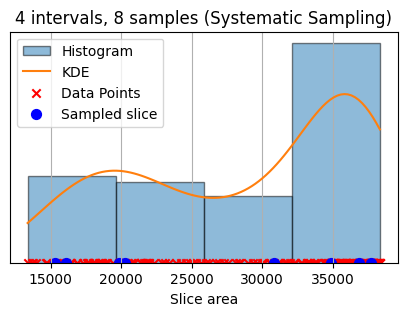

In [94]:
from scipy.stats import gaussian_kde
import numpy as np

# 提供的数据
data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_1'][2:][0]
# 使用gaussian_kde计算Kernel Density Estimate
kde = gaussian_kde(data)

# 为了绘制KDE, 我们需要一个范围和密度值
x_grid = np.linspace(min(data), max(data), 100)
kde_values = kde.evaluate(x_grid)


# 调整抽样策略，使得在数据更密集的区间抽取更多样本，而在稀疏的区间可能不抽取样本
samples_per_bin_adjusted = []
samples_count_per_bin = []

# 指定区间数
k = 4

# 创建k个区间
bins = np.linspace(min(data), max(data), k+1)

# 计算每个区间内的数据点数量
bin_counts = [sum((data >= bins[i]) & (data < bins[i+1])) for i in range(len(bins)-1)]

# 分配样本：每个区间至少一个样本，剩余按比例分配
samples_per_bin = np.ones(k, dtype=int)
remaining_samples = 8 - k  # 减去已分配的样本

# 计算每个区间数据点的比例
proportions = np.array(bin_counts) / sum(bin_counts)

# 根据比例分配剩余样本
additional_samples = np.floor(proportions * remaining_samples).astype(int)
samples_per_bin += additional_samples

# 分配剩余样本（如果有）
remaining_samples -= additional_samples.sum()
while remaining_samples > 0:
    # 按比例选择区间分配剩余样本
    indices = np.argsort(proportions)[::-1][:remaining_samples]
    for i in indices:
        samples_per_bin[i] += 1
        remaining_samples -= 1

data_np = np.array(data)

sampled_values_corrected = []

for i in range(len(bins) - 1):
    bin_data = data_np[(data_np >= bins[i]) & (data_np < bins[i+1])]
    samples_count = samples_per_bin[i]
    
    # 如果区间内的数据点少于要抽取的样本数，则取全部数据点
    if len(bin_data) <= samples_count:
        sampled_values_corrected.extend(bin_data.tolist())
    else:
        # 随机选择区间内指定数量的样本值
        sampled_values_corrected.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

sampled_values_corrected = np.sort(sampled_values_corrected)  # 对抽取的样本值进行排序，以便观察
print(sampled_values_corrected)

sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected]

print(sampled_indices)

# 绘制直方图、KDE和调整后的抽样结果
plt.figure(figsize=(5, 3))
plt.hist(data, bins=bins, density=True, alpha=0.5, edgecolor='black',label='Histogram')

plt.plot(x_grid, kde_values, label='KDE')
plt.scatter(data, np.zeros_like(data), color='red', marker='x', label='Data Points')

# 绘制调整后每个区间抽取的样本
plt.scatter(sampled_values_corrected, np.zeros_like(sampled_values_corrected), color='blue', marker='o', s=50, label='Sampled slice')
plt.gca().get_yaxis().set_visible(False)

# 添加图例（去除重复项）
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('4 intervals, 8 samples (Systematic Sampling)')
plt.xlabel('Slice area')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [98]:
from scipy.stats import gaussian_kde
import numpy as np
def ss_sampling(area_list,start_index,k,sample):
# 提供的数据
    data = area_list
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 调整抽样策略，使得在数据更密集的区间抽取更多样本，而在稀疏的区间可能不抽取样本
    samples_per_bin_adjusted = []
    samples_count_per_bin = []
    # 指定区间数


    # 创建k个区间
    bins = np.linspace(min(data), max(data), k+1)

    # 计算每个区间内的数据点数量
    bin_counts = [sum((data >= bins[i]) & (data < bins[i+1])) for i in range(len(bins)-1)]

    # 分配样本：每个区间至少一个样本，剩余按比例分配
    samples_per_bin = np.ones(k, dtype=int)
    remaining_samples = sample - k  # 减去已分配的样本

    # 计算每个区间数据点的比例
    proportions = np.array(bin_counts) / sum(bin_counts)

    # 根据比例分配剩余样本
    additional_samples = np.floor(proportions * remaining_samples).astype(int)
    samples_per_bin += additional_samples

    # 分配剩余样本（如果有）
    remaining_samples -= additional_samples.sum()
    while remaining_samples > 0:
        # 按比例选择区间分配剩余样本
        indices = np.argsort(proportions)[::-1][:remaining_samples]
        for i in indices:
            samples_per_bin[i] += 1
            remaining_samples -= 1

    data_np = np.array(data)

    sampled_values_corrected = []

    for i in range(len(bins) - 1):
        bin_data = data_np[(data_np >= bins[i]) & (data_np < bins[i+1])]
        samples_count = samples_per_bin[i]
        
        # 如果区间内的数据点少于要抽取的样本数，则取全部数据点
        if len(bin_data) <= samples_count:
            sampled_values_corrected.extend(bin_data.tolist())
        else:
            # 随机选择区间内指定数量的样本值
            sampled_values_corrected.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected = np.sort(sampled_values_corrected)  # 对抽取的样本值进行排序，以便观察
    #print(sampled_values_corrected)

    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected]
    sampled_indices = [x+start_index for x in sampled_indices]
    return sampled_indices

In [9]:
from scipy.integrate import cumtrapz
def kd_sampling(area_list,start_index,k,sample):
# 提供的数据
    data = area_list
    data_np = np.array(data)
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 计算KDE曲线下的面积，以此近似CDF
    cdf = cumtrapz(kde_values, x_grid, initial=0)
    cdf /= cdf[-1]  # 归一化，使得CDF的最大值为1
    # 找出等分的百分位数对应的值作为区间边界
    percentiles = np.linspace(0, 1, k+1)
    bins_percentiles = np.interp(percentiles, cdf, x_grid)

    # 根据新的区间边界进行抽样和绘图过程的剩余部分
    bin_counts_percentiles = [sum((data >= bins_percentiles[i]) & (data < bins_percentiles[i+1])) for i in range(len(bins_percentiles)-1)]
    samples_per_bin_percentiles = np.ones(k, dtype=int)
    remaining_samples_percentiles = sample - k

    proportions_percentiles = np.array(bin_counts_percentiles) / sum(bin_counts_percentiles)
    additional_samples_percentiles = np.floor(proportions_percentiles * remaining_samples_percentiles).astype(int)
    samples_per_bin_percentiles += additional_samples_percentiles

    remaining_samples_percentiles -= additional_samples_percentiles.sum()
    while remaining_samples_percentiles > 0:
        indices_percentiles = np.argsort(proportions_percentiles)[::-1][:remaining_samples_percentiles]
        for i in indices_percentiles:
            samples_per_bin_percentiles[i] += 1
            remaining_samples_percentiles -= 1

    sampled_values_corrected_percentiles = []
    for i in range(len(bins_percentiles) - 1):
        bin_data = data_np[(data_np >= bins_percentiles[i]) & (data_np < bins_percentiles[i+1])]
        samples_count = samples_per_bin_percentiles[i]
        if len(bin_data) <= samples_count:
            sampled_values_corrected_percentiles.extend(bin_data.tolist())
        else:
            sampled_values_corrected_percentiles.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected_percentiles = np.sort(sampled_values_corrected_percentiles)
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected_percentiles]
    sampled_indices = [x+start_index for x in sampled_indices]
    #print(sampled_indices)
    return sampled_indices


[20899. 23308. 24829. 25774. 26710. 27360. 27848. 28166.] [119, 142, 222, 160, 229, 201, 182, 188]


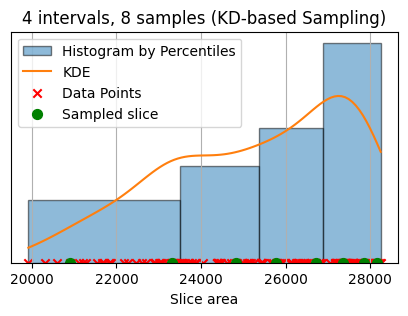

In [164]:
    data = valid_dic['/ssd2/ming/2024COVID/valid_pure_crop_challenge/negative/ct_scan_5'][2:][0]
    data_np = np.array(data)
    # 使用gaussian_kde计算Kernel Density Estimate
    kde = gaussian_kde(data)
    # 为了绘制KDE, 我们需要一个范围和密度值
    x_grid = np.linspace(min(data), max(data), 100)
    kde_values = kde.evaluate(x_grid)
    # 计算KDE曲线下的面积，以此近似CDF
    cdf = cumtrapz(kde_values, x_grid, initial=0)
    cdf /= cdf[-1]  # 归一化，使得CDF的最大值为1
    k=4
    # 找出等分的百分位数对应的值作为区间边界
    percentiles = np.linspace(0, 1, k+1)
    bins_percentiles = np.interp(percentiles, cdf, x_grid)

    # 根据新的区间边界进行抽样和绘图过程的剩余部分
    bin_counts_percentiles = [sum((data >= bins_percentiles[i]) & (data < bins_percentiles[i+1])) for i in range(len(bins_percentiles)-1)]
    samples_per_bin_percentiles = np.ones(k, dtype=int)
    remaining_samples_percentiles = 8 - k

    proportions_percentiles = np.array(bin_counts_percentiles) / sum(bin_counts_percentiles)
    additional_samples_percentiles = np.floor(proportions_percentiles * remaining_samples_percentiles).astype(int)
    samples_per_bin_percentiles += additional_samples_percentiles

    remaining_samples_percentiles -= additional_samples_percentiles.sum()
    while remaining_samples_percentiles > 0:
        indices_percentiles = np.argsort(proportions_percentiles)[::-1][:remaining_samples_percentiles]
        for i in indices_percentiles:
            samples_per_bin_percentiles[i] += 1
            remaining_samples_percentiles -= 1

    sampled_values_corrected_percentiles = []
    for i in range(len(bins_percentiles) - 1):
        bin_data = data_np[(data_np >= bins_percentiles[i]) & (data_np < bins_percentiles[i+1])]
        samples_count = samples_per_bin_percentiles[i]
        if len(bin_data) <= samples_count:
            sampled_values_corrected_percentiles.extend(bin_data.tolist())
        else:
            sampled_values_corrected_percentiles.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected_percentiles = np.sort(sampled_values_corrected_percentiles)
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected_percentiles]

    sampled_indices = [x+116 for x in sampled_indices]

    # 绘制调整后的直方图和KDE
    plt.figure(figsize=(5, 3))
    plt.hist(data_np, bins=bins_percentiles, density=True, alpha=0.5, edgecolor='black', label='Histogram by Percentiles')
    plt.plot(x_grid, kde_values, label='KDE')
    #plt.scatter(sampled_values_corrected_percentiles, np.zeros_like(sampled_values_corrected_percentiles) - 0.01, color='green', marker='o', s=50, label='Sampled by KDE Percentiles')
    plt.gca().get_yaxis().set_visible(False)
    #sampled_values_corrected, np.zeros_like(sampled_values_corrected)
    plt.scatter(data, np.zeros_like(data), color='red', marker='x', label='Data Points')

    plt.scatter(sampled_values_corrected_percentiles, np.zeros_like(sampled_values_corrected), color='green', marker='o', s=50, label='Sampled slice')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    print(sampled_values_corrected_percentiles,sampled_indices)
    plt.title('4 intervals, 8 samples (KD-based Sampling)')
    plt.xlabel('Slice area')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [122]:
sampled_values_corrected_percentiles

array([15641., 20591., 23195., 26657., 27266., 29109., 29250., 30573.])

In [66]:
def equal_length_sampling(area_list,start_index,k,sample):

    k = 8
    # 创建k个区间
    bins = np.linspace(min(data), max(data), k+1)
    # 计算每个区间内的数据点数量
    bin_counts = [sum((data >= bins[i]) & (data < bins[i+1])) for i in range(len(bins)-1)]
    # 分配样本：每个区间至少一个样本，剩余按比例分配
    samples_per_bin = np.ones(k, dtype=int)
    remaining_samples = 16 - k  # 减去已分配的样本
    # 计算每个区间数据点的比例
    proportions = np.array(bin_counts) / sum(bin_counts)
    # 根据比例分配剩余样本
    additional_samples = np.floor(proportions * remaining_samples).astype(int)
    samples_per_bin += additional_samples
    # 分配剩余样本（如果有）
    remaining_samples -= additional_samples.sum()
    while remaining_samples > 0:
        # 按比例选择区间分配剩余样本
        indices = np.argsort(proportions)[::-1][:remaining_samples]
        for i in indices:
            samples_per_bin[i] += 1
            remaining_samples -= 1

    data_np = np.array(data)

    sampled_values_corrected = []

    for i in range(len(bins) - 1):
        bin_data = data_np[(data_np >= bins[i]) & (data_np < bins[i+1])]
        samples_count = samples_per_bin[i]
        
        # 如果区间内的数据点少于要抽取的样本数，则取全部数据点
        if len(bin_data) <= samples_count:
            sampled_values_corrected.extend(bin_data.tolist())
        else:
            # 随机选择区间内指定数量的样本值
            sampled_values_corrected.extend(np.random.choice(bin_data, samples_count, replace=False).tolist())

    sampled_values_corrected = np.sort(sampled_values_corrected)  # 对抽取的样本值进行排序，以便观察
    sampled_indices = [np.where(data_np == value)[0][0] for value in sampled_values_corrected]
    sampled_indices = [x+start_index for x in sampled_indices]

    return sampled_indices

[10875. 14091. 17809. 18618. 22248. 23036. 24335. 25296. 26386. 26663.
 27550. 28683. 29364. 29811. 30745. 30872.]
[1, 8, 18, 21, 33, 37, 46, 49, 55, 57, 65, 77, 83, 154, 98, 97]


In [114]:
sampled_indices = [x+116 for x in sampled_indices]
sampled_indices

[119, 126, 135, 140, 149, 163, 184, 254]